<h1 style="color:#1f77b4; text-align:left; font-size:40px;">
    Modeling
</h1>

<h3 style="color:#555; text-align:left;">
    Algorithms, Train and Validation, hyperparametrization and model comparison
</h3>


<h2 style="color:#1f77b4; border-bottom: 3px solid #1f77b4; padding-bottom:4px;">
</h2>

# **1 Libraries and Data importation**
## **1.1 Import Libraries**

In [1]:
import sys, os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import f1_score

from datetime import datetime

import pandas as pd
from datetime import datetime
import os


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

import os
from datetime import datetime



## **1.2 Import paths to files**

In [2]:
def load_all_processed_data(path: str = "../data/processed"):
    """
    Load all processed data and feature selections from the given path.
    """
    data = {}

    # ============================
    # Base data
    # ============================
    data["X"] = pd.read_parquet(f"{path}/X.parquet")
    data["X_enc"] = pd.read_parquet(f"{path}/X_encoded.parquet")
    data["y"] = pd.read_csv(f"{path}/y.csv")

    # ============================
    # StratifiedKFold parameters
    # ============================
    with open(f"{path}/spkf_params.json", "r") as f:
        skf_params = json.load(f)

    data["skf"] = StratifiedKFold(
        n_splits=skf_params["n_splits"],
        shuffle=skf_params["shuffle"],
        random_state=skf_params["random_state"],
    )

    # ============================
    # Embedded methods - feature lists
    # ============================
    embedded_feature_lists = {
        "xgb_selected_features_embeded": "xgb_selected_features_embeded.json",
        "rf_selected_features_embeded": "rf_selected_features_embeded.json",
        "log_selected_features_embeded": "log_selected_features_embeded.json",
        "dt_selected_features_embeded": "dt_selected_features_embeded.json",
        "log_l1_selected_features_embeded": "log_l1_selected_features_embeded.json",
        "consensus_3of3_embeded": "consensus_3of3_embeded.json",
        "consensus_2of3_embeded": "consensus_2of3_embeded.json",
        "consensus_topN_embeded": "consensus_topN_embeded.json",
    }

    for key, filename in embedded_feature_lists.items():
        with open(f"{path}/{filename}", "r") as f:
            data[key] = json.load(f)

    # Embedded methods - datasets
    embedded_datasets = {
        "X_xgb_embeded": "X_xgb_embeded.parquet",
        "X_rf_embeded": "X_rf_embeded.parquet",
        "X_log_embeded": "X_log_wrapper.parquet",
        "X_dt_embeded": "X_dt_embeded.parquet",
        "X_log_l1_embeded": "X_log_l1_embeded.parquet",
    }

    for key, filename in embedded_datasets.items():
        data[key] = pd.read_parquet(f"{path}/{filename}")

    # ============================
    # Wrapper methods - feature lists
    # ============================
    wrapper_feature_lists = {
        "xgb_selected_features_wrapper": "xgb_selected_features_wrapper.json",
        "rf_selected_features_wrapper": "rf_selected_features_wrapper.json",
        "log_selected_features_wrapper": "log_selected_features_wrapper.json",
        "dt_wrap_selected_features_wrapper": "dt_wrap_selected_features_wrapper.json",
        "consensus_3of3_wrapper": "consensus_3of3_wrapper.json",
        "consensus_2of3_wrapper": "consensus_2of3_wrapper.json",
        "consensus_topN_wrapper": "consensus_topN_wrapper.json",
    }

    for key, filename in wrapper_feature_lists.items():
        with open(f"{path}/{filename}", "r") as f:
            data[key] = json.load(f)

    # Wrapper methods - datasets
    wrapper_datasets = {
        "X_xgb_wrapper": "X_xgb_wrapper.parquet",
        "X_rf_wrapper": "X_rf_wrapper.parquet",
        "X_log_wrapper": "X_log_wrapper.parquet",
        "X_dt_wrap_wrapper": "X_dt_wrap_wrapper.parquet",
    }

    for key, filename in wrapper_datasets.items():
        data[key] = pd.read_parquet(f"{path}/{filename}")

    return data


## **1.3 Load files to dataframes**

In [3]:
# =============================================================
# Load information about Data
# =============================================================

data = load_all_processed_data()

X = data["X"]
X_enc = data["X_enc"]
y = data["y"]
y = y.squeeze()


# =============================================================
# Load information about Data Separation
# =============================================================

skf = data["skf"]

# =============================================================
# Load specific selected features datasets by Embeded Methods
# =============================================================

# Embedded – listas de features
xgb_selected_features_embeded = data["xgb_selected_features_embeded"]
rf_selected_features_embeded = data["rf_selected_features_embeded"]
log_selected_features_embeded = data["log_selected_features_embeded"]

consensus_3of3_embeded = data["consensus_3of3_embeded"]
consensus_2of3_embeded = data["consensus_2of3_embeded"]
consensus_topN_embeded = data["consensus_topN_embeded"]

# Embedded – datasets
#X_xgb_embeded = data["X_xgb_embeded"]
#X_rf_embeded = data["X_rf_embeded"]
#X_log_embeded = data["X_log_embeded"]

# =============================================================
# Load specific selected features datasets by Wrapper Methods
# =============================================================

# Wrapper – listas de features
xgb_selected_features_wrapper = data["xgb_selected_features_wrapper"]
rf_selected_features_wrapper = data["rf_selected_features_wrapper"]
log_selected_features_wrapper = data["log_selected_features_wrapper"]

consensus_3of3_wrapper = data["consensus_3of3_wrapper"]
consensus_2of3_wrapper = data["consensus_2of3_wrapper"]
consensus_topN_wrapper = data["consensus_topN_wrapper"]

# Wrapper – datasets
#X_xgb_wrapper = data["X_xgb_wrapper"]
#X_rf_wrapper = data["X_rf_wrapper"]
#X_log_wrapper = data["X_log_wrapper"]

## **1.4 Creating dataframes to be tested**

In [4]:
#Subset 1: all_data
all_data_enc = pd.concat([X_enc, y], axis=1)

#Subset 2: Embedded features
df_xgb_selected_features_embeded = pd.concat([X_enc[xgb_selected_features_embeded], y], axis=1)
df_rf_selected_features_embeded = pd.concat([X_enc[rf_selected_features_embeded], y], axis=1)
df_log_selected_features_embeded = pd.concat([X_enc[log_selected_features_embeded], y], axis=1)

df_consensus_3of3_embeded = pd.concat([X_enc[consensus_3of3_embeded], y], axis=1)
df_consensus_2of3_embeded = pd.concat([X_enc[consensus_2of3_embeded], y], axis=1)
df_consensus_topN_embeded = pd.concat([X_enc[consensus_topN_embeded], y], axis=1)

#Subset 3: Wrapper features
df_xgb_selected_features_wrapper = pd.concat([X_enc[xgb_selected_features_wrapper], y], axis=1)
df_rf_selected_features_wrapper = pd.concat([X_enc[rf_selected_features_wrapper], y], axis=1)
df_log_selected_features_wrapper = pd.concat([X_enc[log_selected_features_wrapper], y], axis=1)

df_consensus_3of3_wrapper = pd.concat([X_enc[consensus_3of3_wrapper], y], axis=1)
df_consensus_2of3_wrapper = pd.concat([X_enc[consensus_2of3_wrapper], y], axis=1)
df_consensus_topN_wrapper = pd.concat([X_enc[consensus_topN_wrapper], y], axis=1)

# dictionary with all feature subsets
subsets = {
    "all_data_enc": X_enc,

    # Embedded features
    "xgb_embed": X_enc[xgb_selected_features_embeded],
    "rf_embed": X_enc[rf_selected_features_embeded],
    "log_embed": X_enc[log_selected_features_embeded],
    "consensus_3of3_embed": X_enc[consensus_3of3_embeded],
    "consensus_2of3_embed": X_enc[consensus_2of3_embeded],
    "consensus_topN_embed": X_enc[consensus_topN_embeded],

    # Wrapper features
    "xgb_wrapper": X_enc[xgb_selected_features_wrapper],
    "rf_wrapper": X_enc[rf_selected_features_wrapper],
    "log_wrapper": X_enc[log_selected_features_wrapper],
    "consensus_3of3_wrapper": X_enc[consensus_3of3_wrapper],
    "consensus_2of3_wrapper": X_enc[consensus_2of3_wrapper],
    "consensus_topN_wrapper": X_enc[consensus_topN_wrapper],
}



# **2 Model Selection**
## **2.1 Auxiliary Functions to deal with Model Selection**

### **2.1.1 Encode Data**

In [5]:
def encode_data(dataset, to_encode_cols):

    ########################################## CREATE DUMMIES #################################################
    # Create dummies and remove one of the variables (to avoid multicollinearity)
    # 1. Criar dummies
    dummies = pd.get_dummies(dataset[to_encode_cols], drop_first=True)
    # 2. Remover colunas originais
    dataset_remaining = dataset.drop(columns=to_encode_cols)
    # 3. Juntar tudo
    final_dataset = pd.concat([dataset_remaining, dummies], axis=1)
    return final_dataset

### **2.1.2 Sub to train models**

In [6]:
def select_best_models(X_enc, y, model, skf, scale: bool=True):

    score_train, score_val = [],[]

    # perform the cross-validation
    for train_index, val_index in skf.split(X_enc,y):
        X_train, X_val = X_enc.iloc[train_index], X_enc.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if scale:
            # scale the data
            scaler = MinMaxScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)

        # apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return avg_train, std_train, avg_val, std_val

### **2.1.3 Sub to show results**

In [7]:
def show_results(df, X_enc, y, skf, models, scales):
    """
    df      : DataFrame onde vais guardar os resultados (uma linha por modelo)
    X_enc   : feature matrix já encodada
    y       : target (0/1)
    skf     : StratifiedKFold
    models  : lista de modelos [model_XGB, model_RF, model_LOG, ...]
    scales  : lista de bools [False, False, True, ...] se precisa de scaling
    """
    for i, model in enumerate(models):
        scale_flag = scales[i]
        avg_train, std_train, avg_val, std_val = select_best_models(
            X_enc, y, model, skf, scale=scale_flag
        )
        df.iloc[i] = (
            f"{avg_train} +/- {std_train}",
            f"{avg_val} +/- {std_val}"
        )
    return df


## **2.2 Model Instances**
### **2.2.1 XGBoost**

In [8]:
#calculos auxiliares para lidar com desbalanceamento
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos

model_XGB = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=99,
    n_jobs=-1
)


### **2.2.2 Random Forest**

In [9]:
model_RF = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=99,
    n_jobs=-1,
    class_weight="balanced_subsample"  # ativa isto se o target estiver desequilibrado
)


### **2.2.3 Logistic Regression (with StandardScaler)**

In [10]:
model_LOG = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=99
    ))
])


## **2.3 Model Training**

In [11]:
results = {}

results["XGB"] = select_best_models(X_enc, y, model_XGB, skf, scale=False)
results["RF"] = select_best_models(X_enc, y, model_RF, skf, scale=False)
results["LOG"] = select_best_models(X_enc, y, model_LOG, skf, scale=True)


In [12]:
"Create a Dataframe with the columns ['Train', 'Validation] and the index [XGB','RF','LOG'] named as df_all."
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['XGB','RF','LOG'])

In [13]:
# =======================================
# 0. Ensure output folder exists
# =======================================

output_dir = "../data/processed/Model_results"
os.makedirs(output_dir, exist_ok=True)

# =======================================
# 1. Build dictionary of subsets (encoded only)
# =======================================

subsets_for_models = {
    "all_data_enc": X_enc,

    # Embedded subsets
    "xgb_embed": X_enc[xgb_selected_features_embeded],
    "rf_embed": X_enc[rf_selected_features_embeded],
    "log_embed": X_enc[log_selected_features_embeded],
    "consensus_3of3_embed": X_enc[consensus_3of3_embeded],
    "consensus_2of3_embed": X_enc[consensus_2of3_embeded],
    "consensus_topN_embed": X_enc[consensus_topN_embeded],

    # Wrapper subsets
    "xgb_wrapper": X_enc[xgb_selected_features_wrapper],
    "rf_wrapper": X_enc[rf_selected_features_wrapper],
    "log_wrapper": X_enc[log_selected_features_wrapper],
    "consensus_3of3_wrapper": X_enc[consensus_3of3_wrapper],
    "consensus_2of3_wrapper": X_enc[consensus_2of3_wrapper],
    "consensus_topN_wrapper": X_enc[consensus_topN_wrapper],
}

# =======================================
# 2. Evaluate all models on all subsets
# =======================================

models = [model_XGB, model_RF, model_LOG]
scales = [False, False, True]

all_results_list = []

for subset_name, X_sub in subsets_for_models.items():
    print(f"Running models for subset: {subset_name} (shape={X_sub.shape})")

    tmp_results = pd.DataFrame(
        index=["XGB", "RF", "LOG"],
        columns=["Train F1", "Validation (F1)"]
    )

    tmp_results = show_results(tmp_results, X_sub, y, skf, models, scales)

    tmp_results["Subset"] = subset_name
    tmp_results["Model"] = tmp_results.index

    all_results_list.append(tmp_results.reset_index(drop=True))

# =======================================
# 3. Final results table
# =======================================

final_results = pd.concat(all_results_list, ignore_index=True)
final_results = final_results[["Subset", "Model", "Train F1", "Validation (F1)"]]
final_results.set_index(["Subset", "Model"], inplace=True)

# =======================================
# 4. Timestamp
# =======================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# =======================================
# 5. Save results inside folder
# =======================================

results_csv = os.path.join(output_dir, f"final_results_{timestamp}.csv")
results_xlsx = os.path.join(output_dir, f"final_results_{timestamp}.xlsx")

features_csv = os.path.join(output_dir, f"subset_feature_composition_{timestamp}.csv")
features_xlsx = os.path.join(output_dir, f"subset_feature_composition_{timestamp}.xlsx")

# Save model results
final_results.to_csv(results_csv)
final_results.to_excel(results_xlsx)

# Save feature compositions
subset_feature_dict = {}

subset_feature_dict["all_data"] = list(X.columns)
subset_feature_dict["all_data_enc"] = list(X_enc.columns)

for name, df in subsets_for_models.items():
    subset_feature_dict[name] = list(df.columns)

subset_feature_df = (
    pd.DataFrame.from_dict(subset_feature_dict, orient="index")
    .transpose()
)

subset_feature_df.to_csv(features_csv, index=False)
subset_feature_df.to_excel(features_xlsx, index=False)

print("Saved files:")
print(f" - {results_csv}")
print(f" - {results_xlsx}")
print(f" - {features_csv}")
print(f" - {features_xlsx}")
final_results


Running models for subset: all_data_enc (shape=(7043, 42))
Running models for subset: xgb_embed (shape=(7043, 15))
Running models for subset: rf_embed (shape=(7043, 15))
Running models for subset: log_embed (shape=(7043, 15))
Running models for subset: consensus_3of3_embed (shape=(7043, 42))
Running models for subset: consensus_2of3_embed (shape=(7043, 42))
Running models for subset: consensus_topN_embed (shape=(7043, 20))
Running models for subset: xgb_wrapper (shape=(7043, 26))
Running models for subset: rf_wrapper (shape=(7043, 40))
Running models for subset: log_wrapper (shape=(7043, 37))
Running models for subset: consensus_3of3_wrapper (shape=(7043, 24))
Running models for subset: consensus_2of3_wrapper (shape=(7043, 37))
Running models for subset: consensus_topN_wrapper (shape=(7043, 25))
Saved files:
 - ../data/processed/Model_results\final_results_20251130_223156.csv
 - ../data/processed/Model_results\final_results_20251130_223156.xlsx
 - ../data/processed/Model_results\subset

Train F1 Validation (F1)
Subset                 Model                                
all_data_enc           XGB     0.821 +/- 0.0  0.723 +/- 0.01
                       RF        1.0 +/- 0.0  0.672 +/- 0.02
                       LOG     0.692 +/- 0.0  0.685 +/- 0.01
xgb_embed              XGB     0.745 +/- 0.0  0.704 +/- 0.01
                       RF      0.908 +/- 0.0  0.669 +/- 0.01
                       LOG     0.681 +/- 0.0  0.679 +/- 0.01
rf_embed               XGB    0.784 +/- 0.01  0.685 +/- 0.01
                       RF        1.0 +/- 0.0  0.612 +/- 0.02
                       LOG     0.647 +/- 0.0  0.643 +/- 0.01
log_embed              XGB       0.7 +/- 0.0  0.677 +/- 0.01
                       RF      0.766 +/- 0.0  0.644 +/- 0.01
                       LOG      0.66 +/- 0.0   0.66 +/- 0.01
consensus_3of3_embed   XGB     0.822 +/- 0.0  0.724 +/- 0.01
                       RF        1.0 +/- 0.0  0.664 +/- 0.03
                       LOG     0.692 +/- 0.0  0.685 +/- 0.01
consensus_2of3_embed   XGB     0.822 +/- 0.0  0.724 +/- 0.01
                       RF        1.0 +/- 0.0  0.664 +/- 0.03
                       LOG     0.692 +/- 0.0  0.685 +/- 0.01
consensus_topN_embed   XGB     0.782 +/- 0.0  0.709 +/- 0.01
                       RF        1.0 +/- 0.0  0.674 +/- 0.02
                       LOG     0.686 +/- 0.0  0.685 +/- 0.01
xgb_wrapper            XGB     0.805 +/- 0.0  0.723 +/- 0.02
                       RF        1.0 +/- 0.0  0.682 +/- 0.02
                       LOG      0.69 +/- 0.0  0.685 +/- 0.01
rf_wrapper             XGB     0.821 +/- 0.0  0.726 +/- 0.01
                       RF        1.0 +/- 0.0  0.667 +/- 0.03
                       LOG     0.689 +/- 0.0  0.682 +/- 0.01
log_wrapper            XGB      0.81 +/- 0.0  0.723 +/- 0.01
                       RF        1.0 +/- 0.0  0.677 +/- 0.03
                       LOG     0.691 +/- 0.0  0.687 +/- 0.01
consensus_3of3_wrapper XGB     0.799 +/- 0.0  0.715 +/- 0.01
                       RF        1.0 +/- 0.0   0.68 +/- 0.03
                       LOG     0.689 +/- 0.0  0.687 +/- 0.01
consensus_2of3_wrapper XGB     0.815 +/- 0.0  0.723 +/- 0.01
                       RF        1.0 +/- 0.0  0.676 +/- 0.03
                       LOG     0.688 +/- 0.0  0.684 +/- 0.01
consensus_topN_wrapper XGB     0.813 +/- 0.0  0.718 +/- 0.02
                       RF        1.0 +/- 0.0  0.673 +/- 0.02
                       LOG     0.687 +/- 0.0  0.684 +/- 0.01

# **3 Model Optimization**
## **3.1 Auxiliary Functions**

In [14]:
def point_plot(train, validation, values_try):
    sns.pointplot(x=values_try, y=train, color = 'teal', label = 'Train')
    sns.pointplot(x=values_try, y=validation, color = 'goldenrod', label = 'Validation')
    plt.legend()

In [15]:
# Example: choose one of your best-performing subsets
X_tune = subsets_for_models["consensus_3of3_wrapper"]  # <-- muda este nome se quiseres
y_tune = y


## **3.1 XGBoost**

In [35]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    # Define search space
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 600)
    }

    model = XGBClassifier(
        **params,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist"  # Faster
    )

    # 5-fold validation score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()

    return score

# Execute Bayesian Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Extract results
validation_scores = [t.value for t in study.trials]
train_scores = [None] * len(validation_scores)  # Not available directly

# Trials index
values_try = list(range(len(validation_scores)))

point_plot(train_scores, validation_scores, values_try)


ModuleNotFoundError: No module named 'optuna'

## **3.2 Random Forest**

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [750, 1000, 1250, 1500],
    "max_depth": [5, 15, 20, 30, None],
    "max_features": ["sqrt", "log2", 0.1, 0.3, 0.5]
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced_subsample"    # <<-- moved here (correct)
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,              # for a more “global” exploration
    cv=skf,                 # your existing StratifiedKFold
    scoring="accuracy",
    return_train_score=True,
    random_state=42,
    n_jobs=-1               # if you want parallelism
)

random_search.fit(X_enc, y)


KeyboardInterrupt: 

In [59]:
results = pd.DataFrame(random_search.cv_results_)

# Keep only the columns we care about
cols = [
    "param_n_estimators",
    "param_max_depth",
    "param_max_features",
    "mean_train_score",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]
results = results[cols]

results_sorted = results.sort_values("mean_test_score", ascending=False)


# ==============================================
# Saving the conclusions to xlx with time stamp
# ===============================================

# 1. Define the directory where the file will be saved
output_dir = "../data/processed/RF_Optimization"

# 2. Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# 3. Create timestamp (YYYYMMDD_HHMMSS)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 4. Build filename
filename = f"RF_PARAM_OPTIMIZATION_{timestamp}.xlsx"

# 5. Full path
filepath = os.path.join(output_dir, filename)

# 6. Save the Excel file
results_sorted.to_excel(filepath, index=False)

print(f"Ficheiro guardado em: {filepath}")

results_sorted


Ficheiro guardado em: ../data/processed/RF_Optimization\RF_PARAM_OPTIMIZATION_20251130_215231.xlsx


,param_n_estimators,param_max_depth,param_max_features,mean_train_score,mean_test_score,std_test_score,rank_test_score
7,1250,15,0.3,0.997764,0.852333,0.011601,1
24,750,None,0.3,1.000000,0.851339,0.011262,2
21,1500,20,0.3,1.000000,0.851056,0.012589,3
10,750,20,0.3,1.000000,0.851055,0.012481,4
20,750,15,0.3,0.997622,0.850914,0.010268,5
23,750,20,0.5,1.000000,0.850629,0.011587,6
6,1000,20,0.5,1.000000,0.850487,0.011575,7
28,1000,15,0.5,0.997480,0.850346,0.011057,8
29,1500,20,log2,1.000000,0.849778,0.010581,9
2,1000,None,sqrt,1.000000,0.849636,0.010616,10


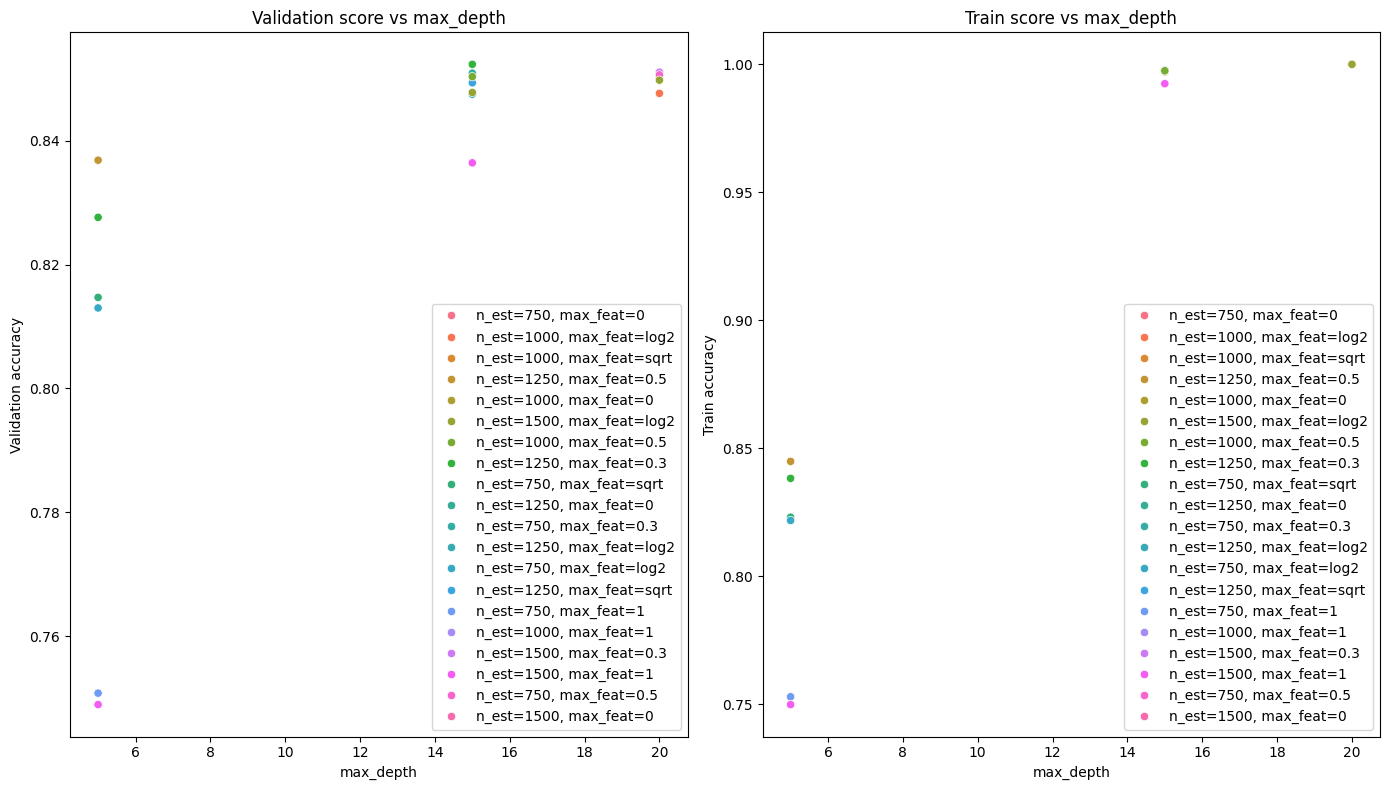

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def combo_label(row):
    return f"n_est={row['param_n_estimators']}, max_feat={row['param_max_features']}"

results["combo"] = results.apply(combo_label, axis=1)


# results = DataFrame construído antes
# já tem as colunas: param_max_depth, mean_train_score, mean_test_score, combo

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# --- VALIDATION ---
sns.scatterplot(
    data=results,
    x="param_max_depth",
    y="mean_test_score",
    hue="combo",
    ax=ax[0]
)

ax[0].set_title("Validation score vs max_depth")
ax[0].legend(loc="lower right")     # <<-- legenda do subplot 0
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("Validation accuracy")

# --- TRAIN ---
sns.scatterplot(
    data=results,
    x="param_max_depth",
    y="mean_train_score",
    hue="combo",
    ax=ax[1]
)

ax[1].set_title("Train score vs max_depth")
ax[1].legend(loc="lower right")      # <<-- legenda do subplot 1
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("Train accuracy")

plt.tight_layout()
plt.show()


## **3.3 Logistic Regression (with StandardScaler)**

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 1. Parameter grid
#param_grid = [
    {
        "penalty": ["l2"],
        "solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"]
    },
    {
        "penalty": ["l1"],
        "solver": ["liblinear", "saga"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"]
    },
    {
        "penalty": ["elasticnet"],
        "solver": ["saga"],
        "l1_ratio": [0.1, 0.5, 0.9],
        "C": [0.001, 0.01, 0.1, 1, 10],
        "class_weight": [None, "balanced"]
    },
    {
        "penalty": ["none"],
        "solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "class_weight": [None, "balanced"]
    }
]

# 2. Model
log_reg = LogisticRegression(max_iter=1000)

# 3. Grid Search using your existing skf
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=skf,                     # <<-- your StratifiedKFold
    scoring="accuracy",
    return_train_score=True
)

grid.fit(X_enc, y)


c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

KeyboardInterrupt: 

In [66]:
results = pd.DataFrame(grid.cv_results_)

cols = [
    "param_C",
    "param_penalty",
    "param_solver",
    "mean_train_score",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]

results = results[cols]
results_sorted = results.sort_values("mean_test_score", ascending=False)


# ==============================================
# Saving the conclusions to xlx with time stamp
# ===============================================
# 1. Output directory
output_dir = "../data/processed/LOGREG_Optimization"
os.makedirs(output_dir, exist_ok=True)

# 2. Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 3. Filename
filename = f"LOGREG_PARAM_OPTIMIZATION_{timestamp}.xlsx"

# 4. Full path
filepath = os.path.join(output_dir, filename)

# 5. Save Excel
results_sorted.to_excel(filepath, index=False)

print(f"Ficheiro guardado em: {filepath}")


results_sorted


Ficheiro guardado em: ../data/processed/LOGREG_Optimization\LOGREG_PARAM_OPTIMIZATION_20251130_221028.xlsx


,param_C,param_penalty,param_solver,mean_train_score,mean_test_score,std_test_score,rank_test_score
9,10.000,l2,lbfgs,0.797778,0.800366,0.011922,1
1,0.001,l2,lbfgs,0.800511,0.797953,0.008751,2
5,0.100,l2,lbfgs,0.797174,0.797953,0.010406,3
7,1.000,l2,lbfgs,0.799553,0.797670,0.012343,4
3,0.010,l2,lbfgs,0.799127,0.797527,0.011606,5
13,100.000,l2,lbfgs,0.799659,0.797527,0.010290,5
11,20.000,l2,lbfgs,0.799730,0.797384,0.015200,7
0,0.001,l1,lbfgs,NaN,NaN,NaN,8
2,0.010,l1,lbfgs,NaN,NaN,NaN,8
4,0.100,l1,lbfgs,NaN,NaN,NaN,8


In [65]:
train_scores = grid.cv_results_["mean_train_score"]
validation_scores = grid.cv_results_["mean_test_score"]
values_try = param_grid["C"]

point_plot(train_scores, validation_scores, values_try)


ValueError: All arrays must be of the same length

<!-- MODELO: Secção principal numerada -->
<!-- 
<h2 style="background-color:#1f77b4; color:white; padding:10px; border-radius:6px;">
    X. Nome da Secção
</h2>
-->

<!-- MODELO: Secção com linha colorida -->
<!-- 
<h2 style="color:#ff7f0e; border-bottom: 3px solid #ff7f0e; padding-bottom:4px;">
    X. Nome da Secção
</h2>
-->

<!-- MODELO: Subsecção -->
<!-- 
<h3 style="color:#2ca02c; margin-top:10px;">
    X.Y Nome da Subsecção
</h3>
-->

<!-- MODELO: Caixa de Nota -->
<!-- 
<div style="border-left: 5px solid #1f77b4; padding:10px; background-color:#f5f9ff; margin:15px 0;">
    <b>Nota:</b> Texto da nota.
</div>
-->